# Debug & test notebook

*Notebook di debugging e testing per il progetto "Segmentazione di edifici da immagini satellitari e classificazione del contesto urbano"*

- **Nome:** Pablo Sebastian
- **Cognome:** Vargas Grateron
- **Email:** pablo.vargasgrateron@studio.unibo.it

## Librerie e percorsi dei dataset

In [11]:
import os, time, torch
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

In [12]:
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Version:", torch.version.cuda)

PyTorch Version: 2.0.1+cu117
CUDA Available: True
CUDA Version: 11.7


In [13]:
PATH_DATASET_DIR = Path("../../dataset")
PATH_DATASET = PATH_DATASET_DIR / "original"
PATH_PROCESSED_DATASET = PATH_DATASET_DIR / "processed"

PATH_TRAIN_DATASET = PATH_DATASET / "train"
PATH_TEST_DATASET = PATH_DATASET / "test"

PATH_TRAIN_DATASET_PROCESSED = PATH_PROCESSED_DATASET / "train"
PATH_TEST_DATASET_PROCESSED = PATH_PROCESSED_DATASET / "test"

PATH_MODEL = Path("model")

## Architettura del modello

In [14]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(self.pool1(x1))
        x3 = self.down3(self.pool2(x2))
        x4 = self.down4(self.pool3(x3))
        x5 = self.bottleneck(self.pool4(x4))

        x = self.up4(x5)
        x = self.conv4(torch.cat([x, x4], dim=1))
        x = self.up3(x)
        x = self.conv3(torch.cat([x, x3], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x, x2], dim=1))
        x = self.up1(x)
        x = self.conv1(torch.cat([x, x1], dim=1))
        return self.final_conv(x)

## Visualizzazione output del modello

> Assicurati di avere il percorso del modello UNet definito nella variabile `MODEL_PATH` prima di eseguire il caricamento del modello.

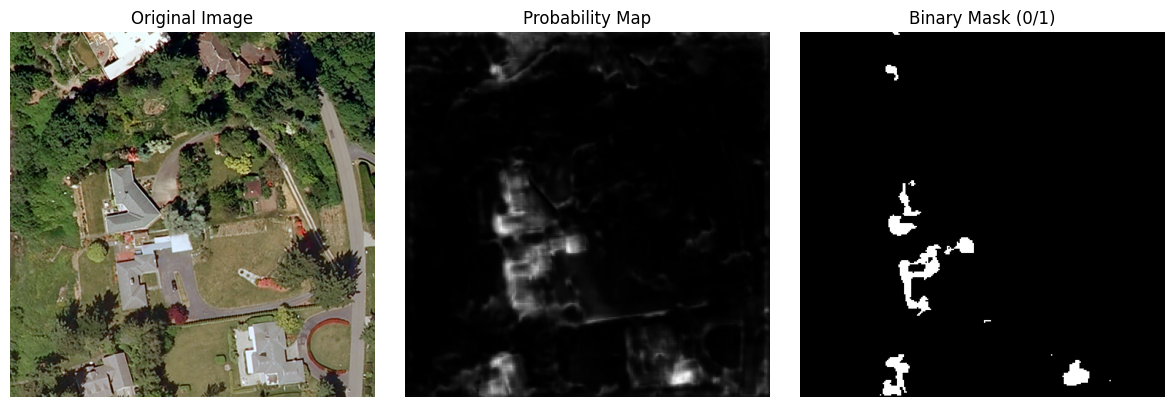

In [15]:
path_current_model = PATH_MODEL / "unet_model1.pth"

model = UNet(in_channels=3, out_channels=1)
model.load_state_dict(torch.load(path_current_model, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Carica immagine
image_path = PATH_TEST_DATASET_PROCESSED / "images" / "bellingham1_x500_y500.tif"
image = Image.open(image_path).convert("RGB")

# Trasformazioni (stesse del training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

input_tensor = transform(image).unsqueeze(0).to(device)

# Inferenza
with torch.no_grad():
    output = model(input_tensor)
    prob_mask = torch.sigmoid(output).squeeze().cpu().numpy()
    bin_mask = (prob_mask > 0.2).astype('float32')

# Mostra risultati
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(prob_mask, cmap="gray")
plt.title("Probability Map")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(bin_mask, cmap="gray")
plt.title("Binary Mask (0/1)")
plt.axis("off")

plt.tight_layout()
plt.show()